# Analyze continuous assay prediction

Here we compare the MTT and LDH regression model performance across representations, and to the random / cell count baselines.

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [2]:
res_dir = "../../1_snakemake/outputs"

dino_pred = f"{res_dir}/dino/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"
cpcnn_pred = f"{res_dir}/cpcnn/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"
cellprofiler_pred = f"{res_dir}/cellprofiler/mad_featselect/classifier_results/axiom_continuous_predictions.parquet"

dino = pl.read_parquet(dino_pred).with_columns(
    pl.lit("DINO").alias("Representation"),
)
cpcnn = pl.read_parquet(cpcnn_pred).with_columns(
    pl.lit("CP-CNN").alias("Representation"),
)
cellprofiler = pl.read_parquet(cellprofiler_pred).with_columns(
    pl.lit("CellProfiler").alias("Representation"),
)

preds = pl.concat([
    dino, cpcnn, cellprofiler
], how="vertical")

# Append cell count
cc = pl.read_parquet(f"{res_dir}/dino/mad_featselect/profiles/mad_featselect.parquet").select(
    ["Metadata_Plate", "Metadata_Well", "Metadata_Count_Cells"]
)

preds = preds.join(cc, on=["Metadata_Plate", "Metadata_Well"])

In [3]:
dino_res = f"{res_dir}/dino/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"
cpcnn_res = f"{res_dir}/cpcnn/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"
cellprofiler_res = f"{res_dir}/cellprofiler/mad_featselect/classifier_results/axiom_continuous_metrics.parquet"

dino = pl.read_parquet(dino_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_DINO")).otherwise(pl.col("Model_type")).alias("Model_type")
).filter(pl.col("Model_type") == "Morphology_DINO")
cpcnn = pl.read_parquet(cpcnn_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_CPCNN")).otherwise(pl.col("Model_type")).alias("Model_type")
).filter(pl.col("Model_type") == "Morphology_CPCNN")
cellprofiler = pl.read_parquet(cellprofiler_res).with_columns(
    pl.when(pl.col("Model_type") == "Morphology").then(pl.lit("Morphology_CellProfiler")).otherwise(pl.col("Model_type")).alias("Model_type")
)

res = pl.concat([
    dino, cpcnn, cellprofiler
], how="vertical").drop("Variable_Name").to_pandas()

In [4]:
# Compute metrics for replicates
dat = pl.read_parquet(f"{res_dir}/dino/mad_featselect/profiles/mad_featselect.parquet").select(
    ["Metadata_Compound", "Metadata_Log10Conc", "Metadata_mtt_ridge_norm", "Metadata_ldh_ridge_norm"]
).filter(
    pl.col("Metadata_Compound") != "DMSO"
)

dat = dat.with_columns(
    pl.arange(0, pl.len()).over(["Metadata_Compound", "Metadata_Log10Conc"]).alias("Replicate_number")
)
dat = dat.with_columns((pl.col("Replicate_number") + 1).alias("Replicate_number"))

dat = dat.pivot(
    index=["Metadata_Compound", "Metadata_Log10Conc"],
    on="Replicate_number",
    values=["Metadata_mtt_ridge_norm", "Metadata_ldh_ridge_norm"],
    aggregate_function="first"
)
dat = dat.select([
    "Metadata_Compound", "Metadata_Log10Conc", "Metadata_mtt_ridge_norm_1", "Metadata_mtt_ridge_norm_2", 
    "Metadata_ldh_ridge_norm_1", "Metadata_ldh_ridge_norm_2"
]).to_pandas()

In [5]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm
import numpy as np
import pandas as pd

groups = dat["Metadata_Compound"]
gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

results = []
for split_idx, (train_idx, test_idx) in tqdm(enumerate(gss.split(dat, groups=groups)), desc=f"Processing"):
    split_dat = dat.iloc[test_idx]

    mtt_split = split_dat[["Metadata_mtt_ridge_norm_1", "Metadata_mtt_ridge_norm_2"]].dropna()
    mtt_1 = mtt_split["Metadata_mtt_ridge_norm_1"]
    mtt_2 = mtt_split["Metadata_mtt_ridge_norm_2"]

    ldh_split = split_dat[["Metadata_ldh_ridge_norm_1", "Metadata_ldh_ridge_norm_2"]].dropna()
    ldh_1 = ldh_split["Metadata_ldh_ridge_norm_1"]
    ldh_2 = ldh_split["Metadata_ldh_ridge_norm_2"]

    # Calculate performance for ldh
    mse = mean_squared_error(ldh_1, ldh_2)
    r2 = r2_score(ldh_1, ldh_2)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ldh_1, ldh_2)
    results.append(("Metadata_ldh_ridge_norm", split_idx, r2, rmse, mae))

    # Calculate performance for mtt
    mse = mean_squared_error(mtt_1, mtt_2)
    r2 = r2_score(mtt_1, mtt_2)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(mtt_1, mtt_2)
    results.append(("Metadata_mtt_ridge_norm", split_idx, r2, rmse, mae))

rep_results = pd.DataFrame(results, columns=["Variable", "Split", "R²", "RMSE", "MAE"])
rep_results["Model_type"] = "Replicates"

res = pd.concat([res, rep_results], axis=0, ignore_index=True)



Processing: 10it [00:00, 88.64it/s]


In [27]:
# Define a function to plot violin and swarm plots grouped by variable types
def violin_swarm_plot_by_variable(df, variable_type, metric):

    df = df[df['Variable'].str.contains(variable_type)]
    
    plt.figure(figsize=(5, 5), dpi=100)
    sns.violinplot(data=df, x="Model_type", y=metric, inner="box", palette="Accent", hue="Model_type", legend=False)
    sns.swarmplot(data=df, x="Model_type", y=metric, color="k", alpha=1, s=3)
    
    # Set custom labels
    plt.xlabel("Model type")
    plt.ylabel(metric)
    #plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [54]:
from plotnine import ggplot, aes, theme_classic, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete, geom_jitter

def boxplot_jitterplot(df, variable_type, metric):
    df_filt = df[df['Variable'].str.contains(variable_type)]

    plot = (
        ggplot(df_filt, aes(x='Model_type', y=metric)) 
        + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
        + geom_jitter(color="black") 
        + labs(x='Model type', y=metric) 
        + theme_classic()
        + theme(axis_text_x=element_text(angle=45, hjust=1))
        + scale_x_discrete(labels={
            "Morphology_DINO": "Morphology (DINO)", 
            "Morphology_CPCNN": "Morphology (CP-CNN)", 
            "Morphology_CellProfiler": "Morphology (CellProfiler)", 
            "Baseline": "Baseline", 
            "Mean_predictor": "Mean predictor",
        })
    )
    plot.show()

Metadata_ldh_ridge_norm
R²


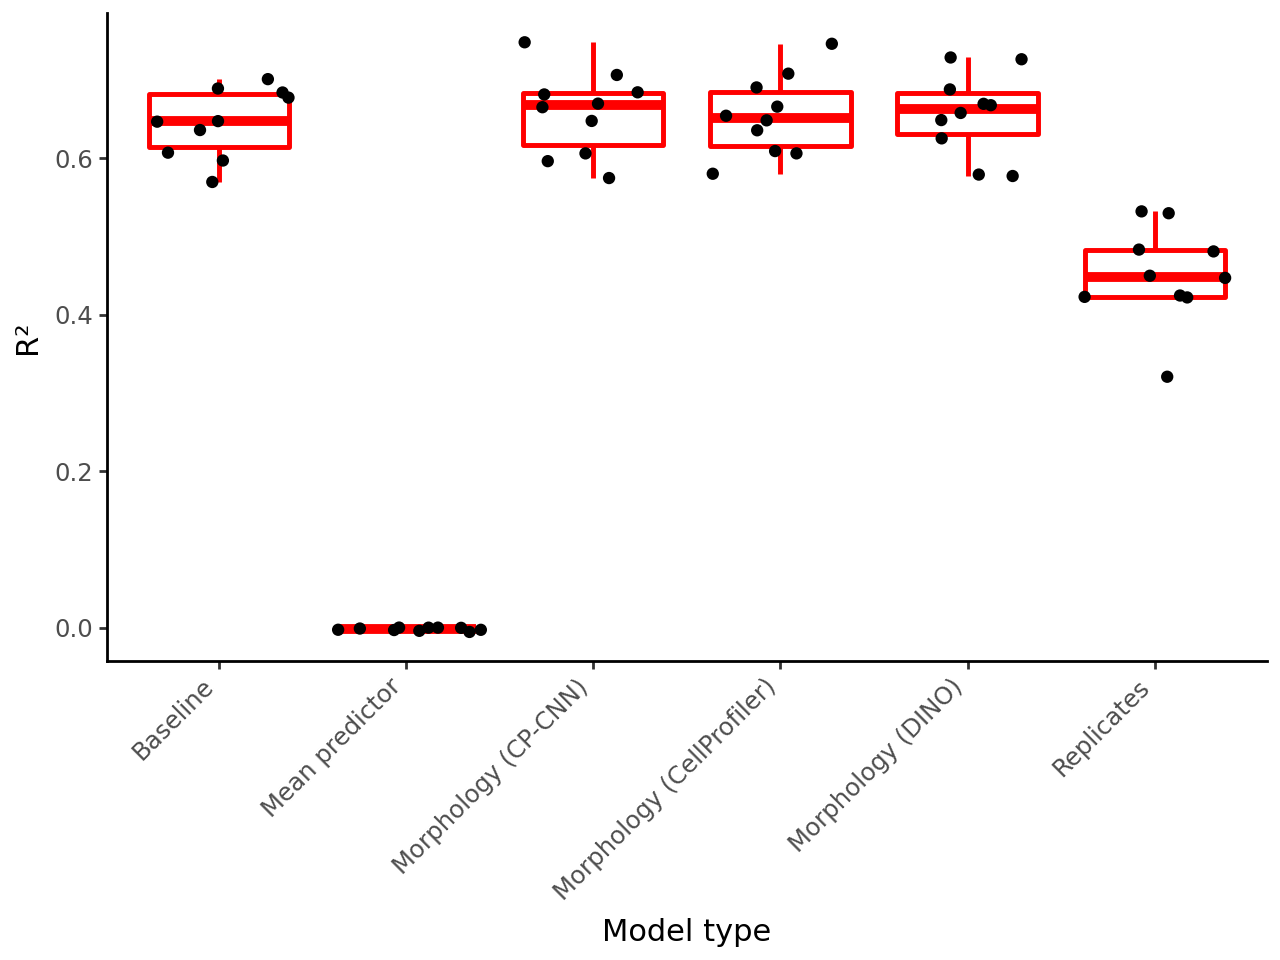

Metadata_ldh_ridge_norm
RMSE


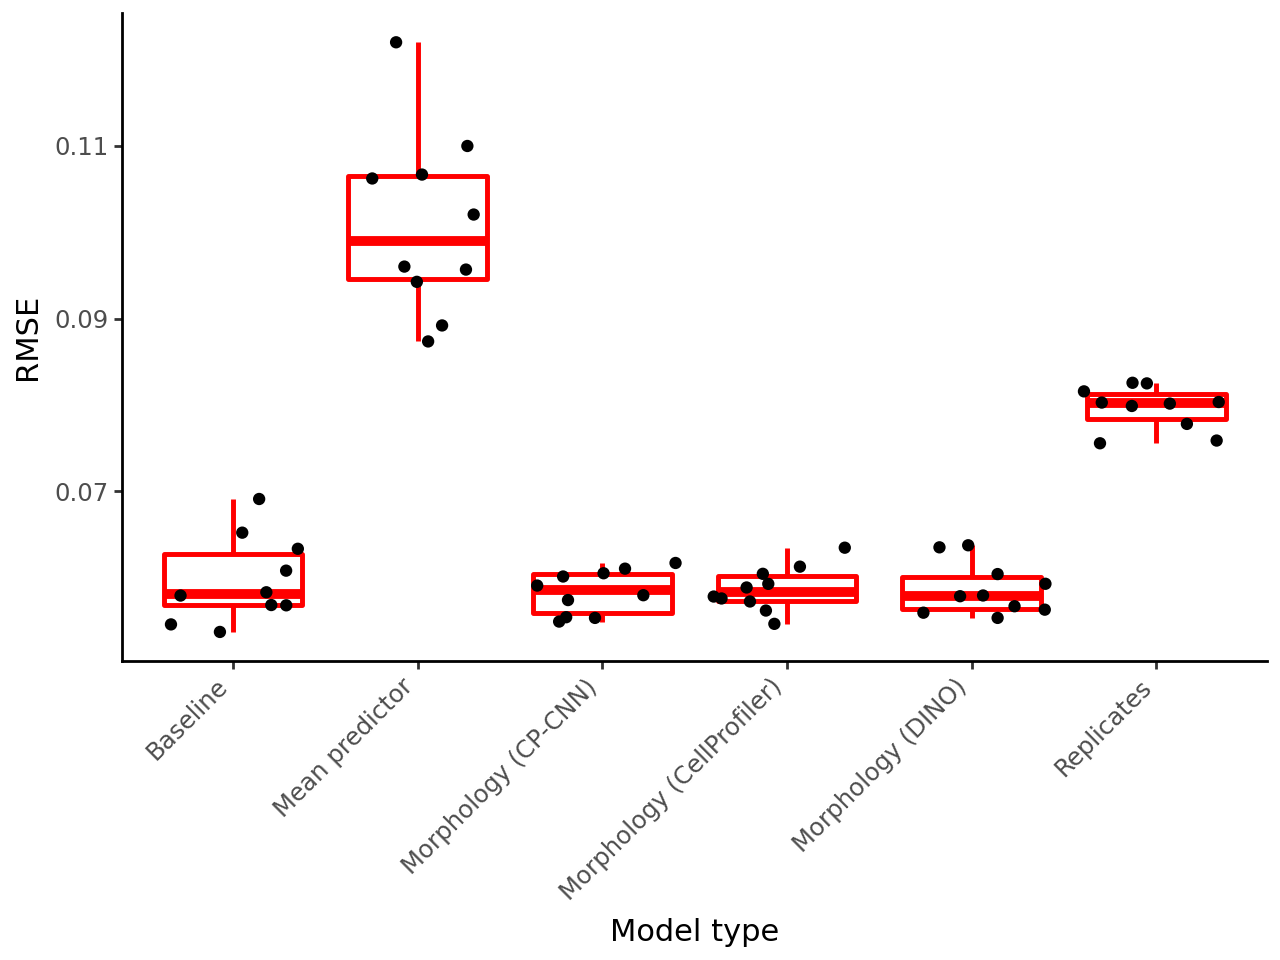

Metadata_ldh_ridge_norm
MAE


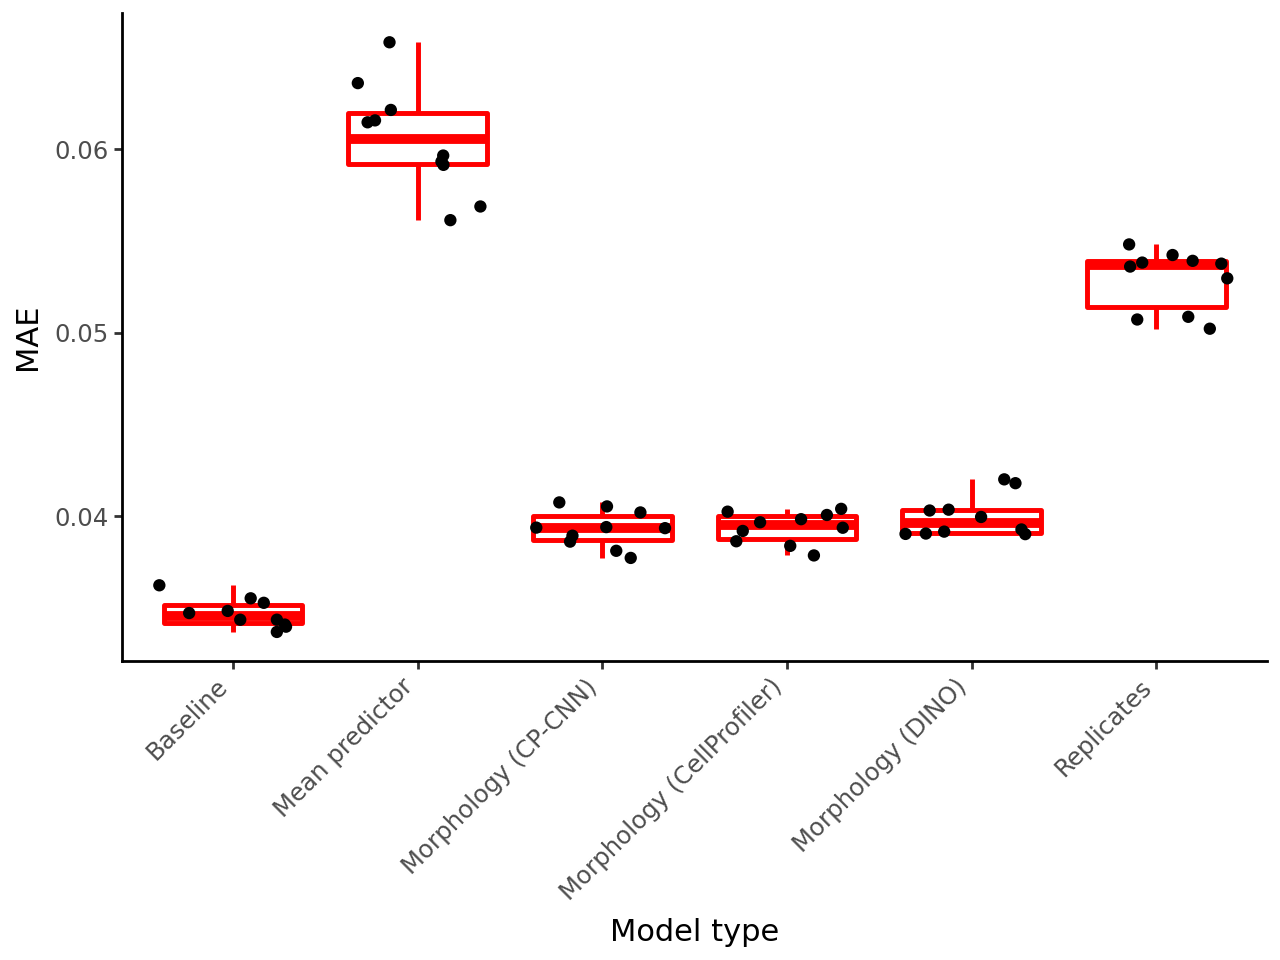

Metadata_mtt_ridge_norm
R²


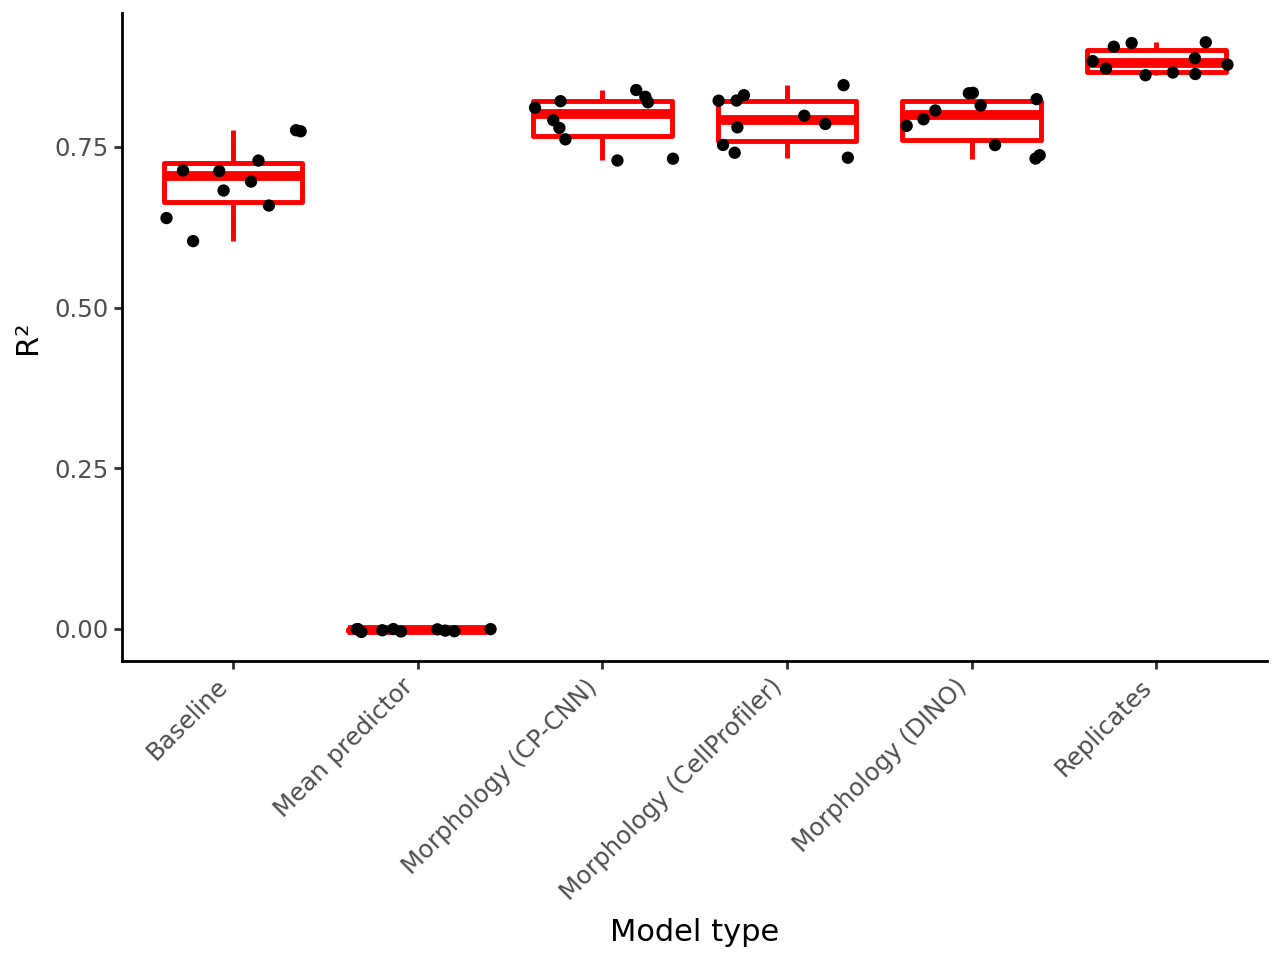

Metadata_mtt_ridge_norm
RMSE


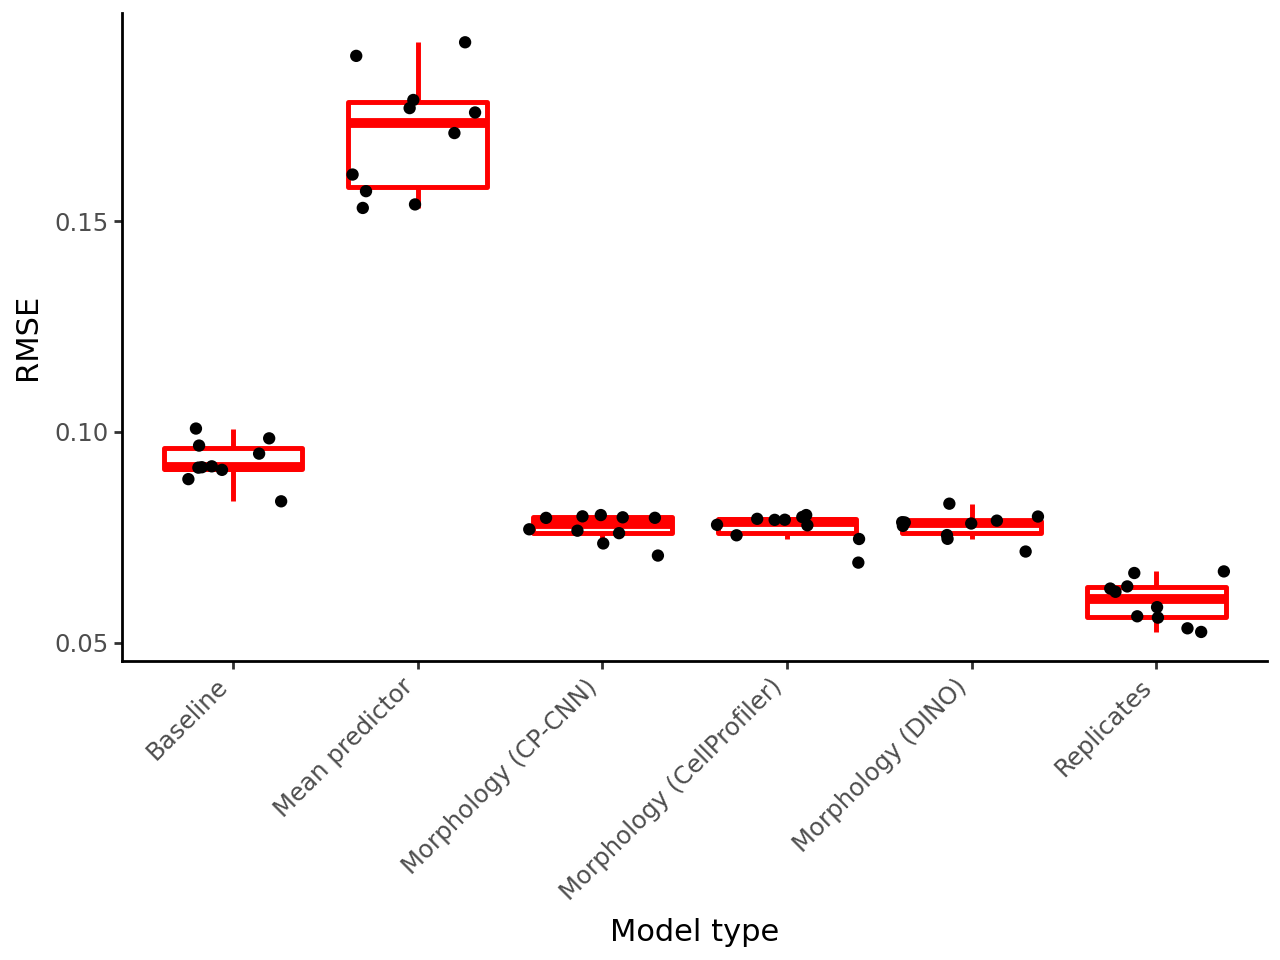

Metadata_mtt_ridge_norm
MAE


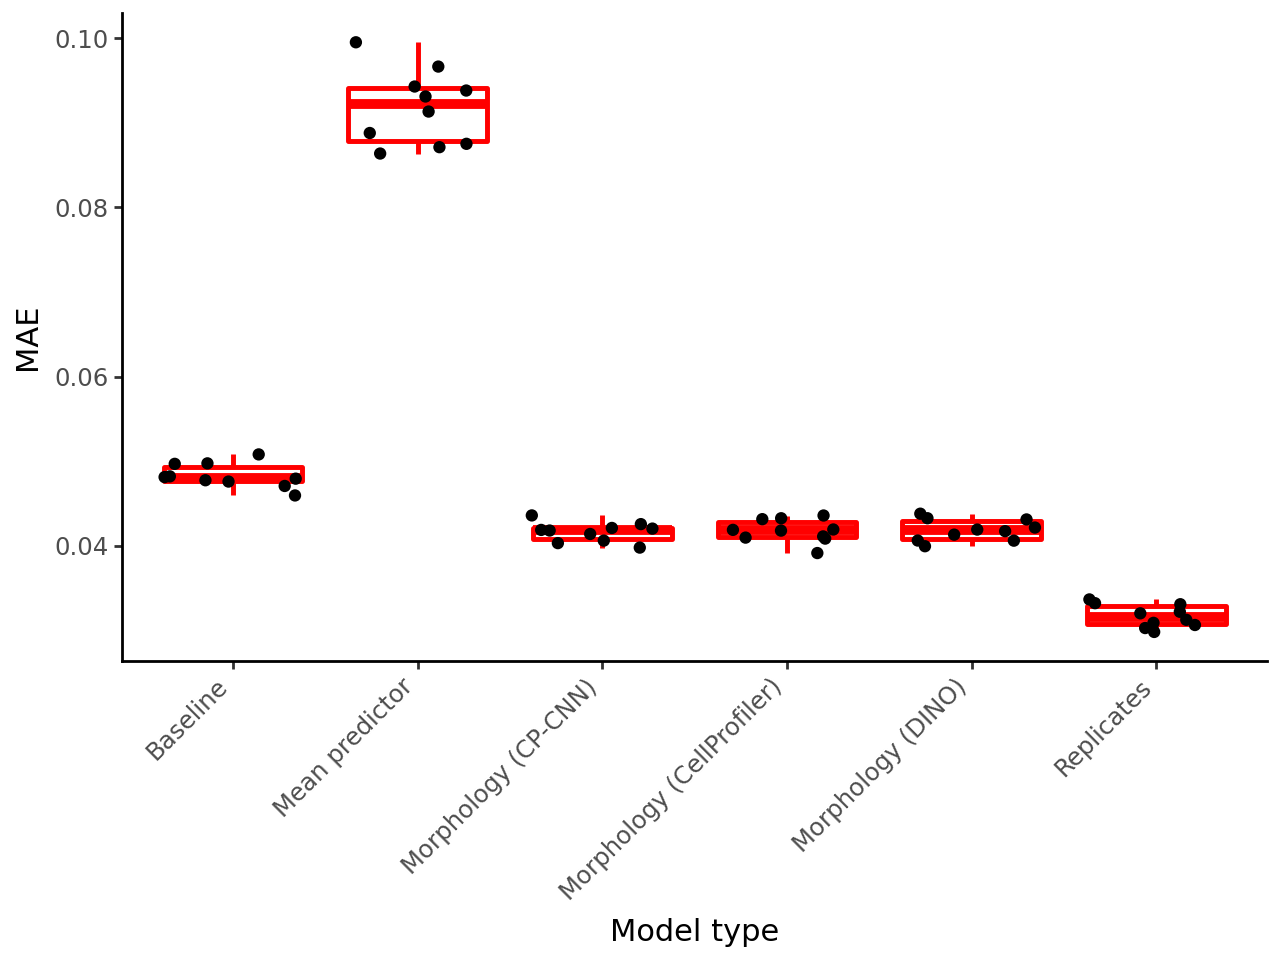

In [94]:
metrics = ["R²", "RMSE", "MAE"]
variable_types = ['Metadata_ldh_ridge_norm', 'Metadata_mtt_ridge_norm']

for variable_type in variable_types:
    for metric in metrics:
        print(variable_type)
        print(metric)
        boxplot_jitterplot(res, variable_type, metric)

In [97]:
summary_df = res.groupby(["Variable", "Model_type"]).agg({
    "R²": ["mean", "std"],
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"]
}).reset_index()

# Flatten the column names for readability
summary_df.columns = ["_".join(col).strip("_") for col in summary_df.columns]

def round_to_2_sigfigs(x):
    if isinstance(x, (int, float)) and not np.isnan(x):  # Ensure the value is numeric
        return float(f"{x:.2g}")
    return x  # Return non-numeric values unchanged

summary_df= summary_df.applymap(round_to_2_sigfigs)

# Display the result
print(summary_df)

                   Variable               Model_type  R²_mean  R²_std  \
0   Metadata_ldh_ridge_norm                 Baseline   0.6500  0.0440   
1   Metadata_ldh_ridge_norm           Mean_predictor  -0.0020  0.0020   
2   Metadata_ldh_ridge_norm         Morphology_CPCNN   0.6600  0.0530   
3   Metadata_ldh_ridge_norm  Morphology_CellProfiler   0.6500  0.0510   
4   Metadata_ldh_ridge_norm          Morphology_DINO   0.6600  0.0520   
5   Metadata_ldh_ridge_norm               Replicates   0.4500  0.0620   
6   Metadata_mtt_ridge_norm                 Baseline   0.7000  0.0550   
7   Metadata_mtt_ridge_norm           Mean_predictor  -0.0019  0.0017   
8   Metadata_mtt_ridge_norm         Morphology_CPCNN   0.7900  0.0400   
9   Metadata_mtt_ridge_norm  Morphology_CellProfiler   0.7900  0.0390   
10  Metadata_mtt_ridge_norm          Morphology_DINO   0.7900  0.0390   
11  Metadata_mtt_ridge_norm               Replicates   0.8800  0.0200   

    RMSE_mean  RMSE_std  MAE_mean  MAE_std  
0    

/tmp/ipykernel_44441/1642972571.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


## Compare predictions across baseline and morphology

In [ ]:
preds = preds.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

pred_mean = preds.group_by([
    "Metadata_Plate", "Metadata_Well", "Model_type", "Metadata_Compound", "Metadata_Log10Conc"
]).agg(
    pl.mean("Diff_pred_obs").alias("Diff_pred_obs")
)

pred_mean = pred_mean.pivot(
    index = ["Metadata_Plate", "Metadata_Well", "Metadata_Compound", "Metadata_Log10Conc"],
    on = "Model_type",
    values = "Diff_pred_obs"
).drop("Mean_predictor").with_columns(
    (pl.col("Baseline") - pl.col("Morphology")).alias("Diff_error"),
    (pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc"], separator="_")).alias("Metadata_Perturbation")
)

In [43]:
preds = preds.with_columns(
    pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID")
)

Predicted,Observed,Metadata_Plate,Metadata_Well,Metadata_Compound,Metadata_OASIS_ID,Metadata_Log10Conc,Variable,Split,Variable_Name,Model_type,Representation,Metadata_Count_Cells,Diff_pred_obs,Metadata_Perturbation,Unique_ID
f64,f64,str,str,str,str,f64,str,i32,str,str,str,u32,f64,str,str
0.062602,0.12059,"""plate_41002688""","""F17""","""Dichlorphenamide""","""OASIS706""",2.36,"""Metadata_ldh_ridge_norm""",1,"""Metadata_ldh_ridge_norm""","""Morphology""","""DINO""",948,-0.057988,"""Dichlorphenamide_2.36""","""Dichlorphenamide_2.36_F17_plat…"
0.046936,0.006382,"""plate_41002688""","""C14""","""Amodiaquine""","""OASIS791""",2.36,"""Metadata_ldh_ridge_norm""",1,"""Metadata_ldh_ridge_norm""","""Morphology""","""DINO""",809,0.040554,"""Amodiaquine_2.36""","""Amodiaquine_2.36_C14_plate_410…"
0.029439,0.078582,"""plate_41002688""","""I13""","""Telaprevir""","""OASIS980""",2.36,"""Metadata_ldh_ridge_norm""",1,"""Metadata_ldh_ridge_norm""","""Morphology""","""DINO""",858,-0.049143,"""Telaprevir_2.36""","""Telaprevir_2.36_I13_plate_4100…"
-0.000738,0.018259,"""plate_41002688""","""E18""","""Zoledronic Acid""","""OASIS664""",2.36,"""Metadata_ldh_ridge_norm""",1,"""Metadata_ldh_ridge_norm""","""Morphology""","""DINO""",850,-0.018997,"""Zoledronic Acid_2.36""","""Zoledronic Acid_2.36_E18_plate…"
-0.006595,0.0,"""plate_41002688""","""B15""","""Midodrine""","""OASIS633""",2.36,"""Metadata_ldh_ridge_norm""",1,"""Metadata_ldh_ridge_norm""","""Morphology""","""DINO""",780,-0.006595,"""Midodrine_2.36""","""Midodrine_2.36_B15_plate_41002…"


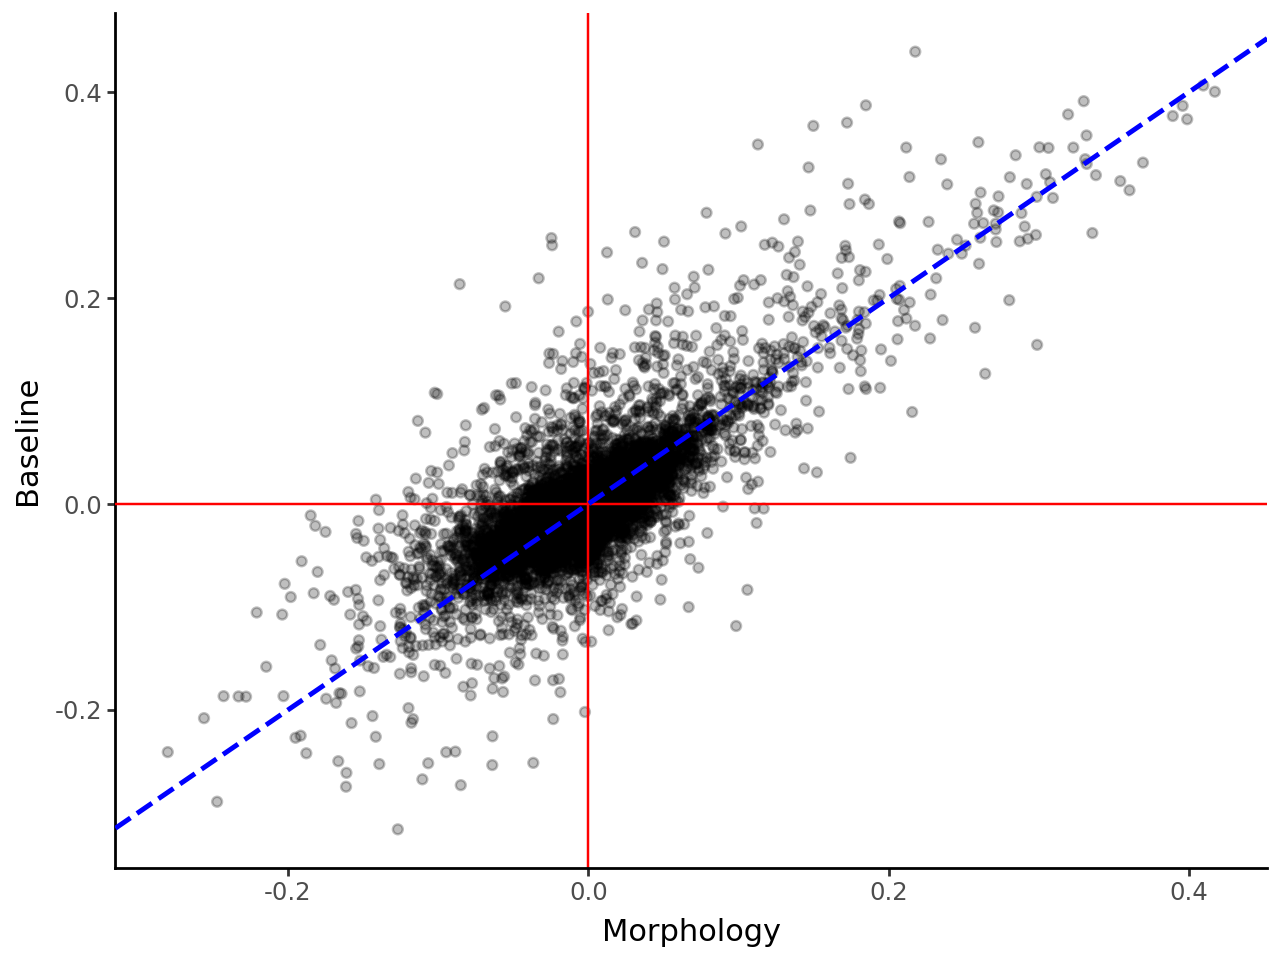

In [24]:
from plotnine import ggplot, aes, theme_classic, labs, geom_point, geom_abline, geom_vline, geom_hline

plot = (
    ggplot(pred_mean, aes(x='Morphology', y="Baseline"))
    + geom_point(alpha=0.25)
    + geom_vline(xintercept=0, linetype="solid", color="red", size=0.5)
    + geom_hline(yintercept=0, linetype="solid", color="red", size=0.5)
    + geom_abline(slope=1, intercept=0, linetype="dashed", color="blue", size=1)
    + theme_classic()
)
plot.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 260'. Pick better value with 'binwidth'.


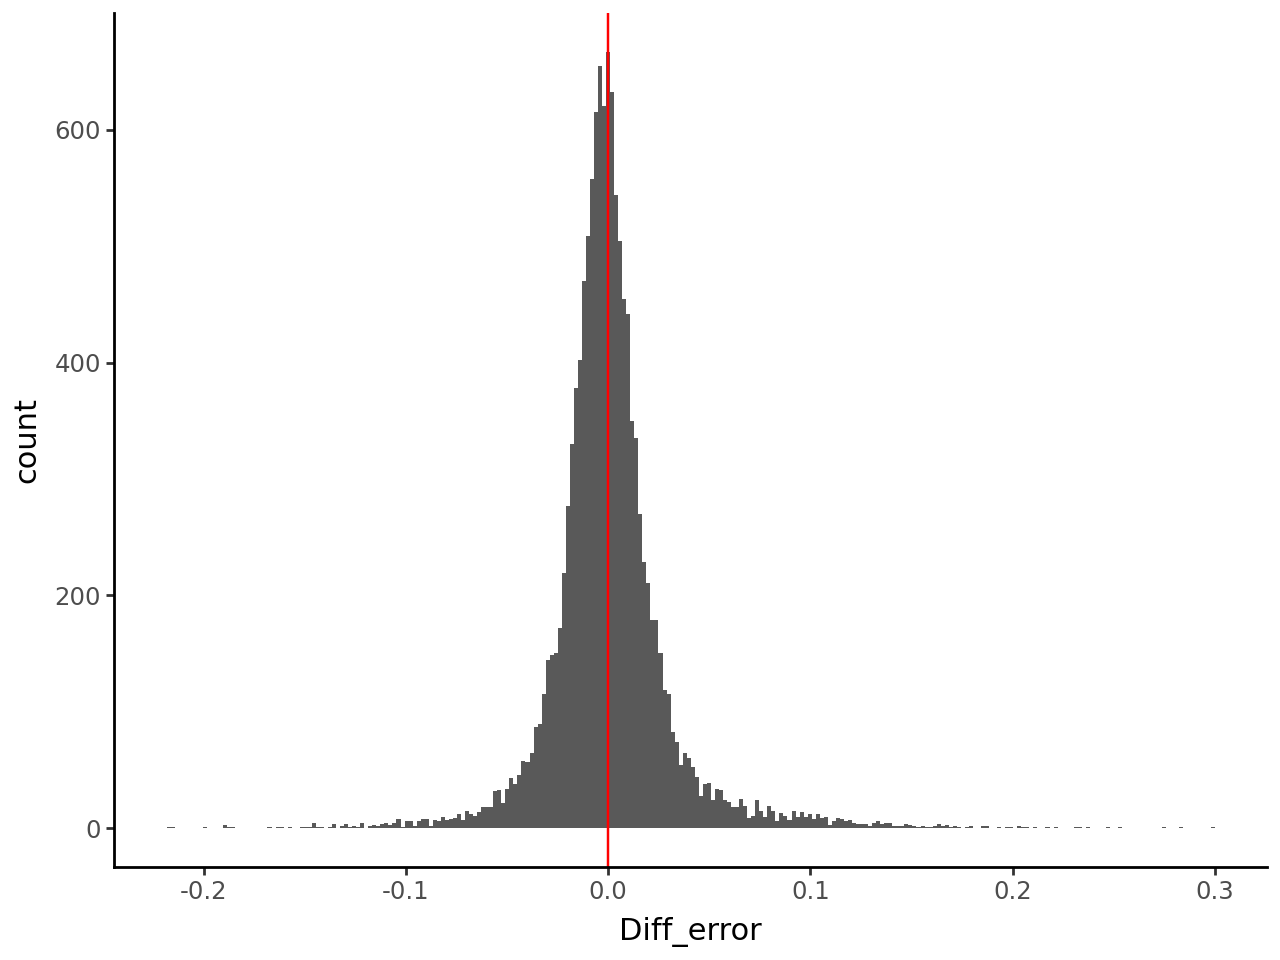

In [17]:
from plotnine import ggplot, aes, theme_classic, labs, geom_histogram, geom_vline

plot = (
    ggplot(pred_mean, aes(x='Diff_error'))
    + geom_histogram()
    + geom_vline(xintercept=0, linetype="solid", color="red", size=0.5)
    + theme_classic()
)
plot.show()

In [37]:
# Create Motive target set library
meta = pl.read_parquet("../../1_snakemake/inputs/metadata/metadata.parquet").with_columns(
    pl.col("Metadata_Log10Conc").round(2).alias("Metadata_Log10Conc")
)
targets = pl.read_parquet("../../1_snakemake/inputs/annotations/cg_motive.parquet")
targets = targets.filter(pl.col("interaction_type") == "unknown_direction")
targets = targets.select(["target", "OASIS_ID"]).unique()

target_set_size = targets.select(pl.col("target").value_counts()).unnest("target").filter(pl.col("count") >= 3)
keep_sets = target_set_size.select("target").to_series().to_list()
targets = targets.filter(pl.col("target").is_in(keep_sets))

cmpd_meta = meta.select(["Metadata_OASIS_ID", "Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"]).with_columns(
    pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID")
).drop(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"]).rename({"Metadata_OASIS_ID": "OASIS_ID"})

targets = targets.join(cmpd_meta, on="OASIS_ID").select(["target", "Unique_ID"]).unique().rename({"target": "target_set"})

In [30]:
import polars as pl
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def overrepresentation_analysis(target_set_library: pl.DataFrame, target_hits: list, universe: list):
    target_hits_set = set(target_hits)
    universe_set = set(universe)
    sets = target_set_library.select(pl.col("target_set")).unique().to_series()
    results = []

    # For each target set, calculate the overlap and perform the hypergeometric test
    for target_set in tqdm(sets):
        targets_in_set = set(target_set_library.filter(pl.col("target_set") == target_set)["Unique_ID"].to_list())
        
        overlap = target_hits_set.intersection(targets_in_set)
        overlap_size = len(overlap)

        M = len(universe_set)  # Total number of genes in the universe
        n = len(targets_in_set)  # Number of genes in the gene set
        N = len(target_hits_set)  # Number of gene hits
        x = overlap_size  # Number of overlapping genes (successes)

        p_value = hypergeom.sf(x - 1, M, n, N)

        results.append({
            "target_set": target_set,
            "overlap_size": overlap_size,
            "target_set_size": n,
            "hit_list_size": N,
            "universe_size": M,
            "p_value": p_value,
            "overlap_hits": ",".join(overlap),
        })

    return pl.DataFrame(results)

# FDR adjust the p-values
def fdr_polars(df: pl.DataFrame):
    p_values = df.select("p_value").to_series().to_numpy()
    _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    df = df.with_columns(pl.Series("fdr", p_adjusted))
    return df

In [25]:
# Define outliers
std = pred_mean.select(pl.col("Diff_error").std()).to_numpy()[0][0]
thresh = std*2.58 # 2.58 std = p-val 0.01

pred_mean = pred_mean.with_columns(
    pl.when(pl.col("Diff_error") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_error") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

print(pred_mean.shape)
pred_mean.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

(13176, 10)


Outlier_flag,count
str,u32
"""Lower""",138
"""Normal""",12734
"""Higher""",304


In [26]:
# define lists
higher_err = pred_mean.filter(pl.col("Outlier_flag") == "Higher").select("Unique_ID").to_series().to_list()
lower_err = pred_mean.filter(pl.col("Outlier_flag") == "Lower").select("Unique_ID").to_series().to_list()

universe_err = pred_mean.select("Unique_ID").to_series().unique().to_list()

In [39]:
# Perform overrepresentation analysis
higher_err_results = overrepresentation_analysis(targets, higher_err, universe_err)
lower_err_results = overrepresentation_analysis(targets, lower_err, universe_err)

higher_err_results = fdr_polars(higher_err_results).sort("fdr")
lower_err_results = fdr_polars(lower_err_results).sort("fdr")

100%|██████████| 8858/8858 [00:12<00:00, 685.18it/s]


In [40]:
higher_err_results.write_csv("../compiled_results/err_higher_targets.csv")
lower_err_results.write_csv("../compiled_results/err_lower_targets.csv")

In [66]:
all_mtt = preds.filter(
    pl.col("Variable").str.contains("mtt")
).select(["Observed", "Unique_ID", "Metadata_Count_Cells"]).unique().with_columns(
    pl.lit("All samples").alias("MTT_type")
)

higher_err_mtt = preds.filter(
    pl.col("Unique_ID").is_in(higher_err)
).filter(
    pl.col("Variable").str.contains("mtt")
).select(["Observed", "Unique_ID", "Metadata_Count_Cells"]).unique().with_columns(
    pl.lit("Better predicted by Cell Painting").alias("MTT_type")
)

lower_err_mtt = preds.filter(
    pl.col("Unique_ID").is_in(lower_err)
).filter(
    pl.col("Variable").str.contains("mtt")
).select(["Observed", "Unique_ID", "Metadata_Count_Cells"]).unique().with_columns(
    pl.lit("Better predicted by technical baseline").alias("MTT_type")
)

mtt_preds = pl.concat([
    all_mtt, higher_err_mtt, lower_err_mtt
])

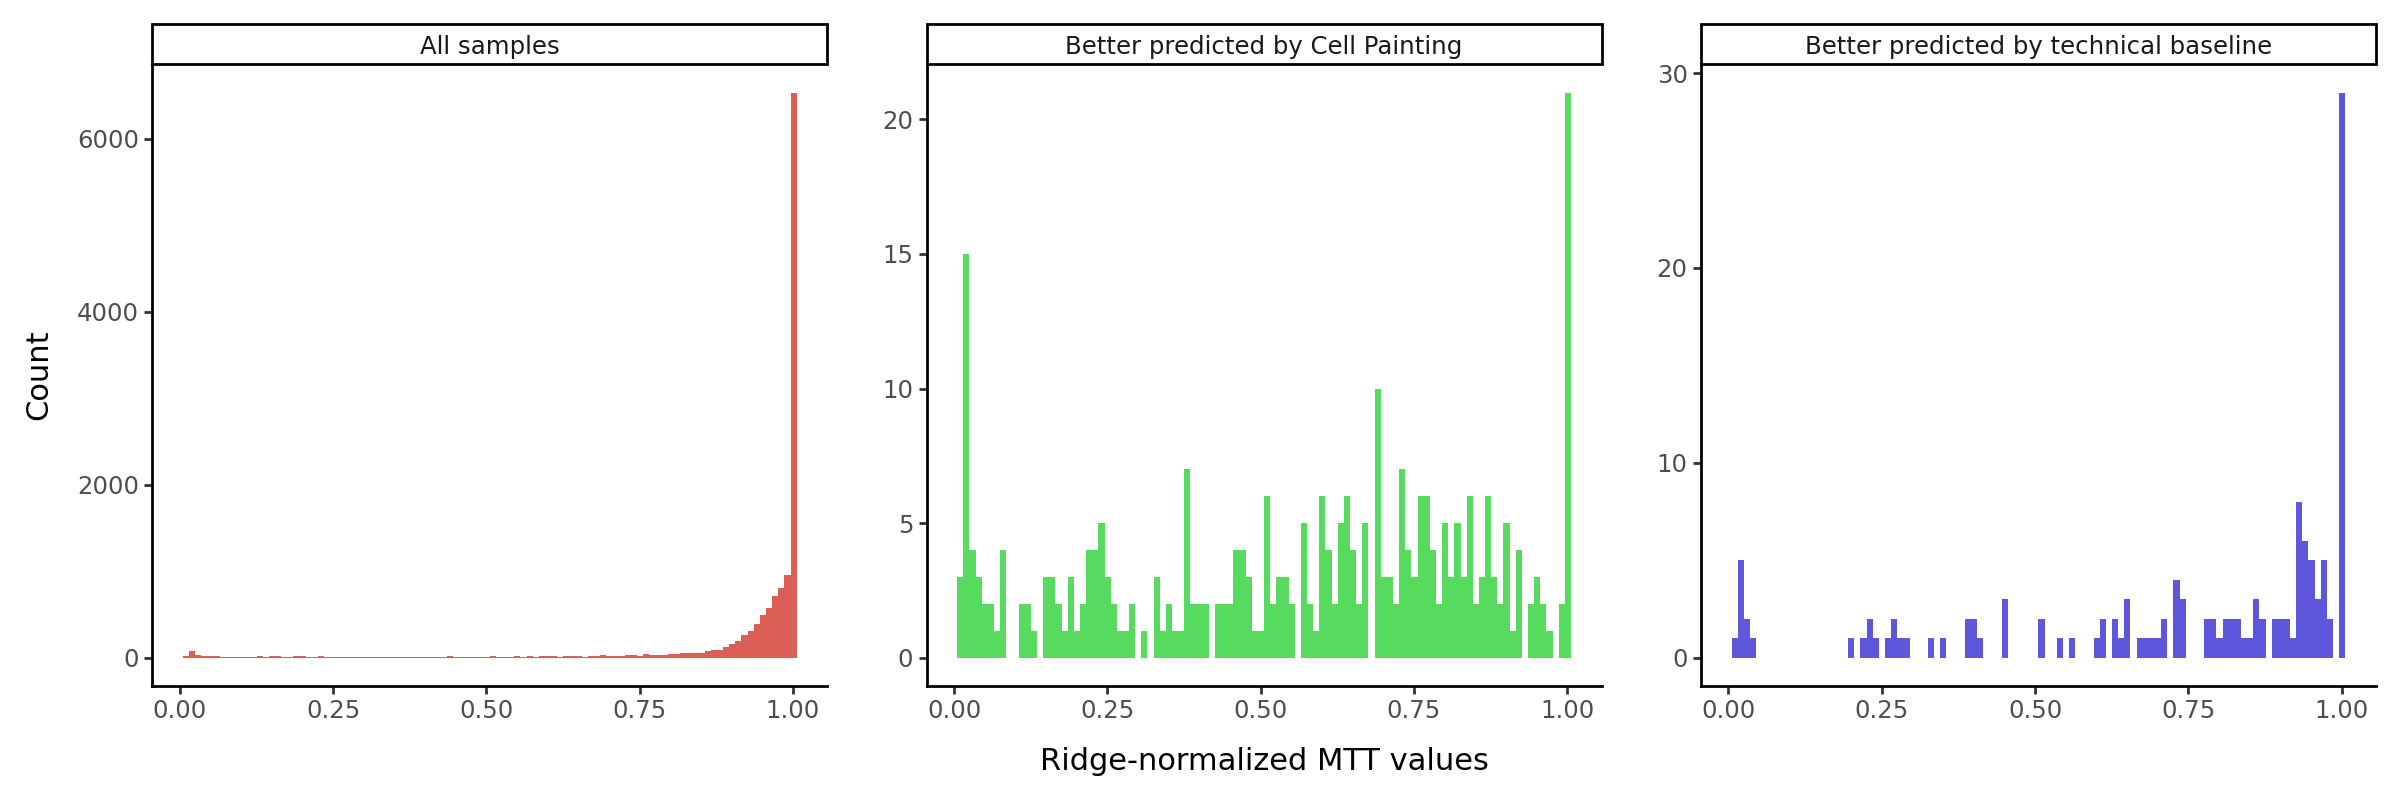

In [65]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, labs, theme_classic, theme
import plotnine as pn
pn.options.figure_size = (12, 4)

plot = (
    ggplot(mtt_preds, aes(x="Observed", fill="MTT_type"))
    + geom_histogram(bins=100)
    + facet_wrap("MTT_type", ncol=3, scales="free_y")
    + labs(
        x="Ridge-normalized MTT values",
        y="Count"
    )
    + theme_classic()
    + theme(legend_position='none')
)
plot.show()

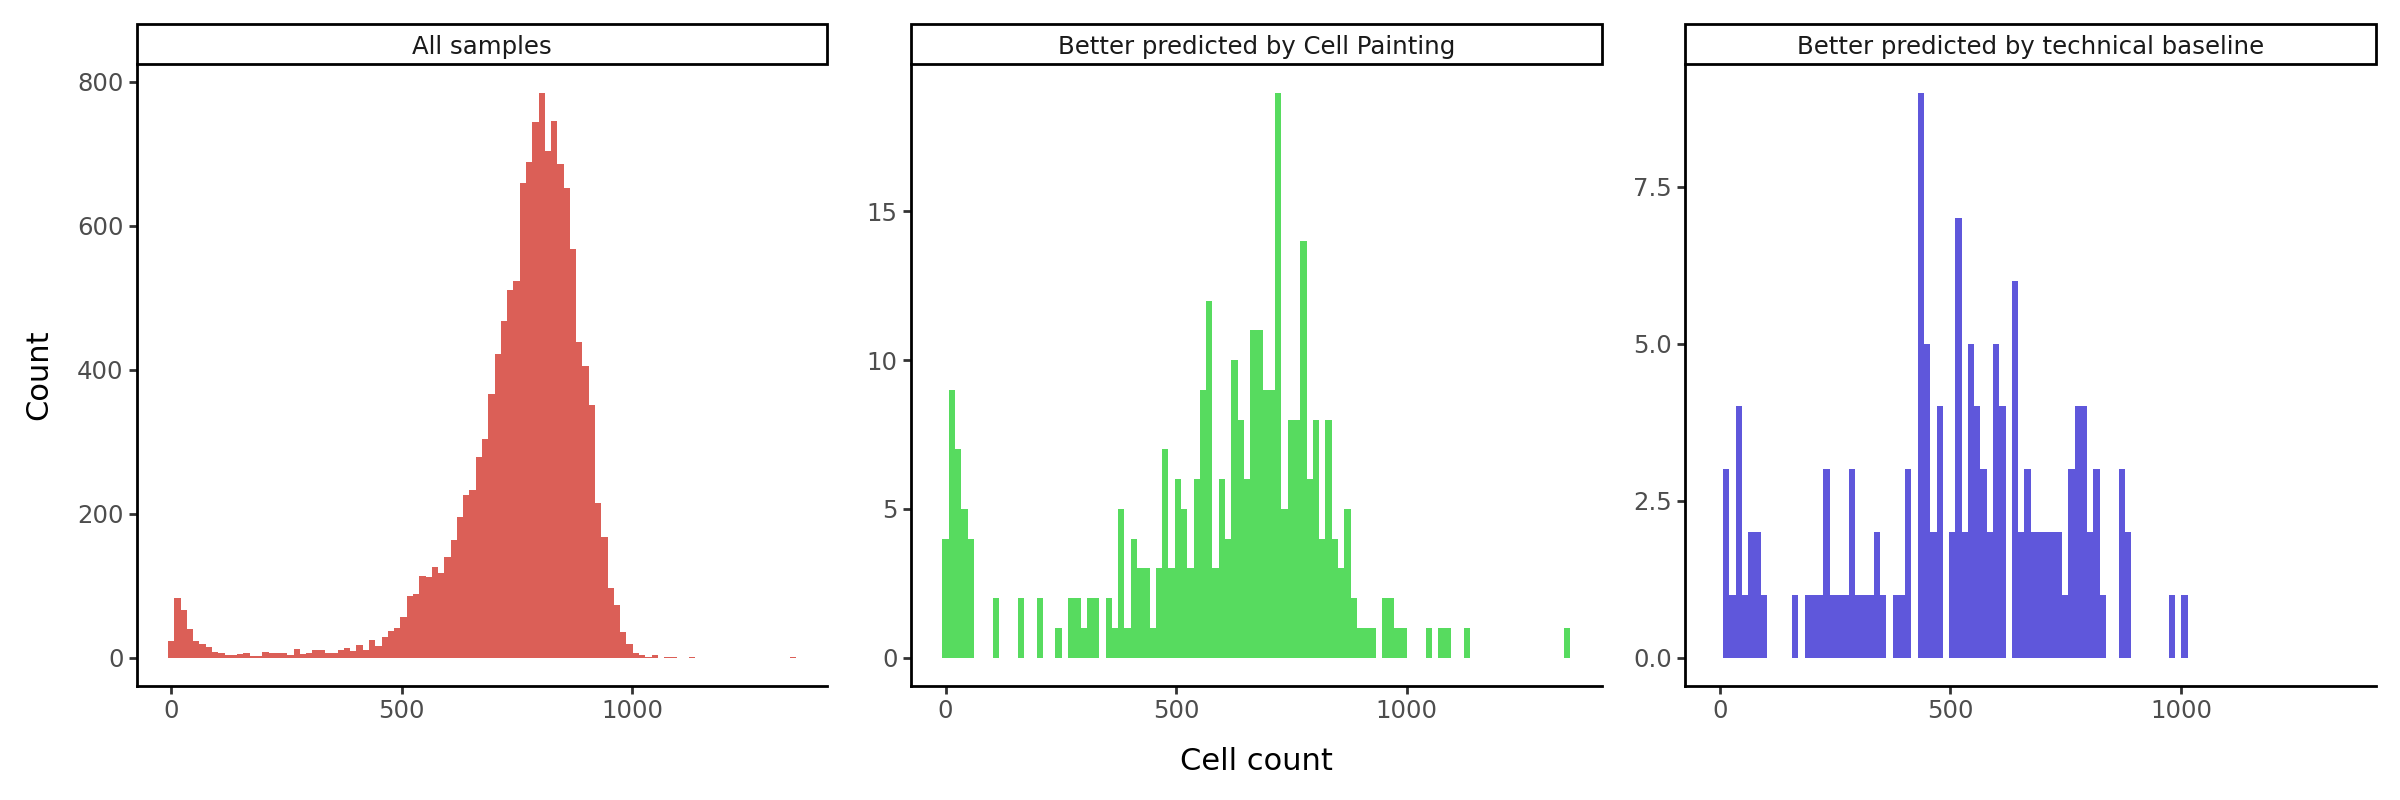

In [67]:
from plotnine import ggplot, aes, geom_histogram, facet_wrap, labs, theme_classic, theme
import plotnine as pn
pn.options.figure_size = (12, 4)

plot = (
    ggplot(mtt_preds, aes(x="Metadata_Count_Cells", fill="MTT_type"))
    + geom_histogram(bins=100)
    + facet_wrap("MTT_type", ncol=3, scales="free_y")
    + labs(
        x="Cell count",
        y="Count"
    )
    + theme_classic()
    + theme(legend_position='none')
)
plot.show()

In [68]:
# Look at 
higher_err_plot = higher_err_mtt.filter(
    pl.col("Metadata_Count_Cells") > 500
)

Observed,Unique_ID,Metadata_Count_Cells,MTT_type
f64,str,u32,str
0.664811,"""Belumosudil_3.82_K02_plate_410…",695,"""Better predicted by Cell Paint…"
0.854665,"""Temsirolimus_0.95_D08_plate_41…",912,"""Better predicted by Cell Paint…"
0.575579,"""Selpercatinib_3.34_P08_plate_4…",422,"""Better predicted by Cell Paint…"
0.632864,"""Panobinostat_2.36_G09_plate_41…",559,"""Better predicted by Cell Paint…"
0.461314,"""Calcitriol_3.82_M09_plate_4100…",469,"""Better predicted by Cell Paint…"
…,…,…,…
0.147379,"""Cisapride_3.82_O13_plate_41002…",574,"""Better predicted by Cell Paint…"
0.291843,"""Olaparib_3.82_L05_plate_410028…",578,"""Better predicted by Cell Paint…"
0.230623,"""Difenoconazole_3.82_E11_plate_…",319,"""Better predicted by Cell Paint…"


## Analyze exposures better predicted by Cell Painting

In [116]:
profiles = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet").with_columns(
    pl.col("Metadata_Log10Conc").round(2).alias("Metadata_Log10Conc")
)

profiles = profiles.with_columns(
    pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Metadata_Unique_ID")
)

profiles = profiles.filter(pl.col("Metadata_Unique_ID").is_in(higher_err))
meta_cols = [i for i in profiles.columns if "Metadata" in i]
feat_cols = [i for i in profiles.columns if "Metadata" not in i]

metadata_df = profiles.select(meta_cols).to_pandas()
numerical_df = profiles.select(feat_cols).to_pandas()

import anndata as ad
import scanpy as sc

adata = ad.AnnData(
    X=numerical_df.values,  # Expression matrix as a NumPy array
    obs=metadata_df.set_index("Metadata_Unique_ID"),  # Metadata with cell_id as index
    var=pd.DataFrame(index=feat_cols)  # Feature names as index
)

sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
sc.tl.umap(adata)

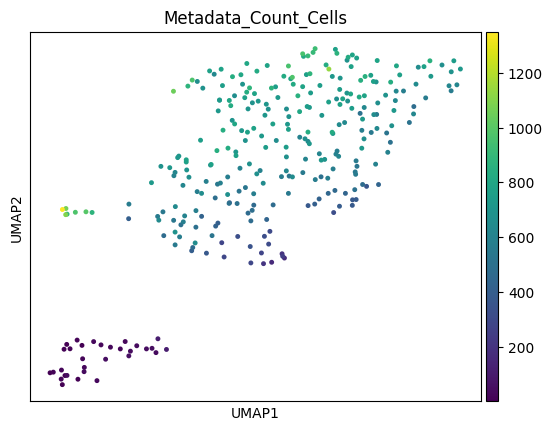

In [117]:
sc.pl.umap(adata, color='Metadata_Count_Cells', size=50)

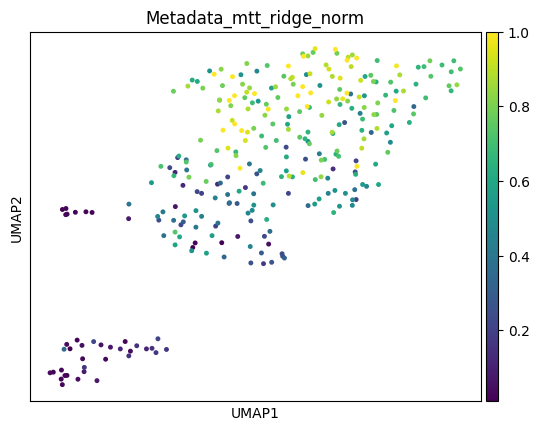

In [87]:
sc.pl.umap(adata, color='Metadata_mtt_ridge_norm', size=50)

In [118]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

cosine_distance_matrix = squareform(pdist(adata.X, metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata_count_cells = adata.obs.reset_index()["Metadata_Count_Cells"]
norm = Normalize(vmin=metadata_count_cells.min(), vmax=metadata_count_cells.max())
normalized_counts = norm(metadata_count_cells.to_numpy())

colormap = sns.color_palette("coolwarm", as_cmap=True)
row_colors = colormap(normalized_counts)

# For categorical
metadata_compound = adata.obs.reset_index()["Metadata_Compound"]
compound_colors = pd.Categorical(metadata_compound).codes
unique_categories = metadata_compound.unique()
palette = sns.color_palette("tab10", len(unique_categories))
compound_color_map = dict(zip(unique_categories, palette))

metadata_compound = metadata_compound.reset_index(drop=True)
metadata_compound = metadata_compound.astype(str)
compound_row_colors = metadata_compound.map(compound_color_map).to_numpy()


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


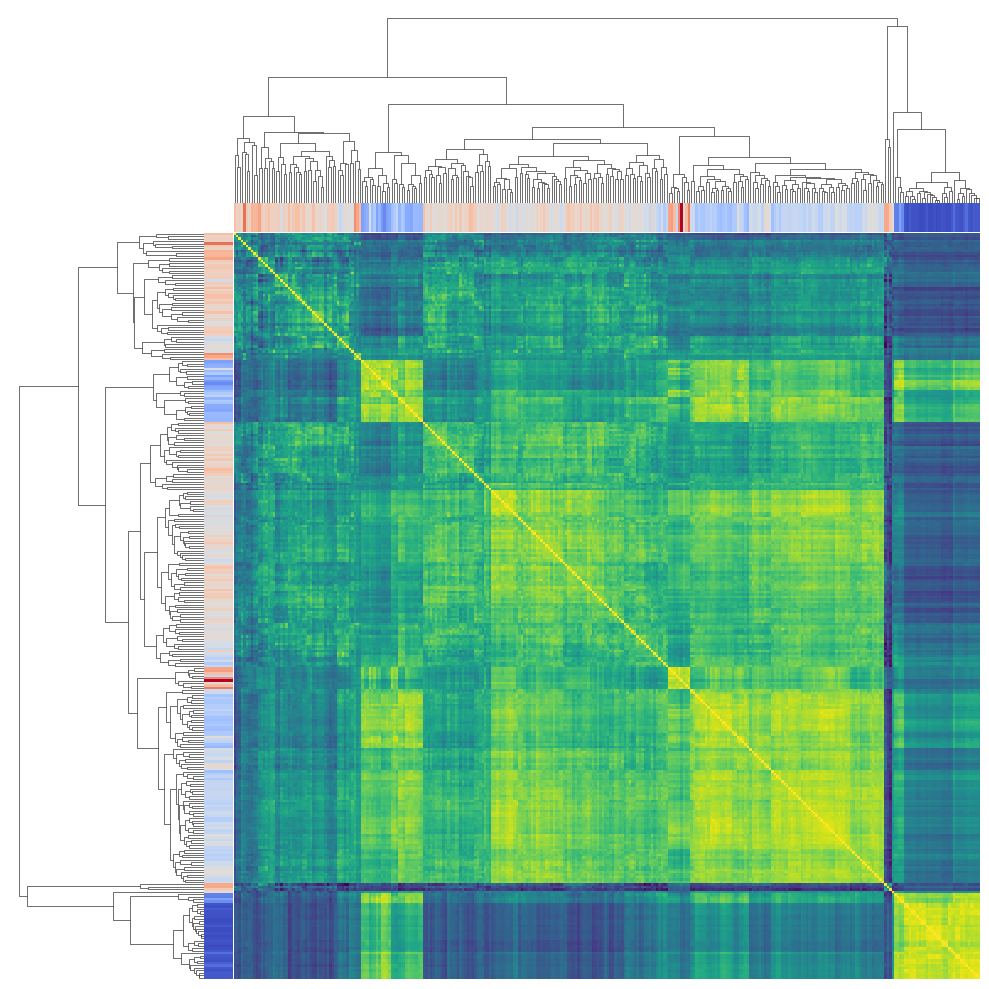

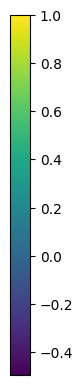

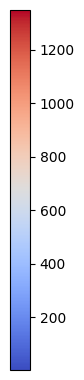

In [119]:
sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 10),
    cbar_pos=None
)

from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

# Separate colorbar for cosine similarity
similarity_norm = Normalize(vmin=cosine_similarity_matrix.min(), vmax=cosine_similarity_matrix.max())
similarity_colorbar = plt.figure(figsize=(1, 6))
sim_cb_ax = similarity_colorbar.add_axes([0.1, 0.2, 0.2, 0.6])  # [left, bottom, width, height]
ColorbarBase(sim_cb_ax, cmap="viridis", norm=similarity_norm, orientation="vertical")
sim_cb_ax.set_label("Cosine Similarity")

# Separate colorbar for cell count
count_norm = Normalize(vmin=metadata_count_cells.min(), vmax=metadata_count_cells.max())
count_colorbar = plt.figure(figsize=(1, 6))
count_cb_ax = count_colorbar.add_axes([0.1, 0.2, 0.2, 0.6])  # [left, bottom, width, height]
ColorbarBase(count_cb_ax, cmap=colormap, norm=count_norm, orientation="vertical")
count_cb_ax.set_label("Cell Count")

plt.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


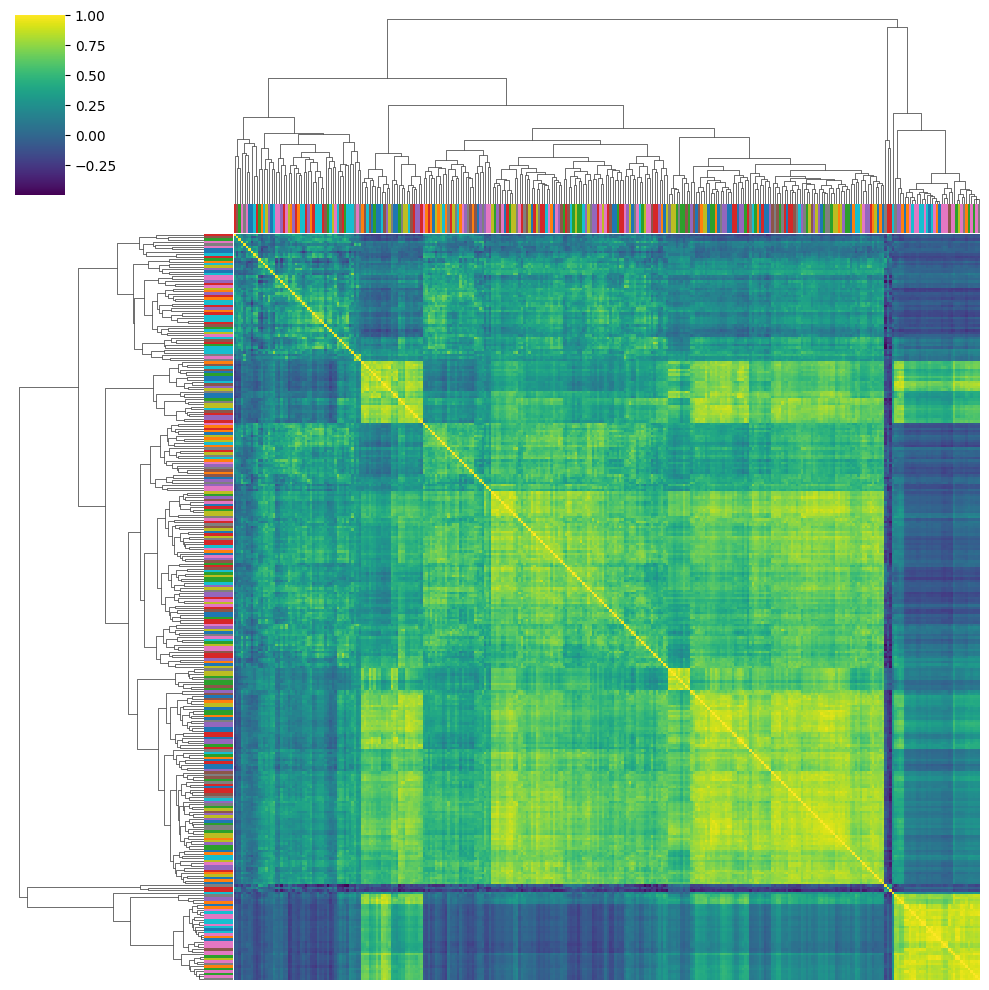

In [96]:
sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=compound_row_colors,
    col_colors=compound_row_colors,
    figsize=(10, 10)
)
plt.show()

## Analyze exposures better predicted by technical baseline

In [104]:
profiles = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet").with_columns(
    pl.col("Metadata_Log10Conc").round(2).alias("Metadata_Log10Conc")
)

profiles = profiles.with_columns(
    pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Metadata_Unique_ID")
)

profiles = profiles.filter(pl.col("Metadata_Unique_ID").is_in(lower_err))
meta_cols = [i for i in profiles.columns if "Metadata" in i]
feat_cols = [i for i in profiles.columns if "Metadata" not in i]

metadata_df = profiles.select(meta_cols).to_pandas()
numerical_df = profiles.select(feat_cols).to_pandas()

import anndata as ad
import scanpy as sc

adata = ad.AnnData(
    X=numerical_df.values,  # Expression matrix as a NumPy array
    obs=metadata_df.set_index("Metadata_Unique_ID"),  # Metadata with cell_id as index
    var=pd.DataFrame(index=feat_cols)  # Feature names as index
)

sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')
sc.tl.umap(adata)

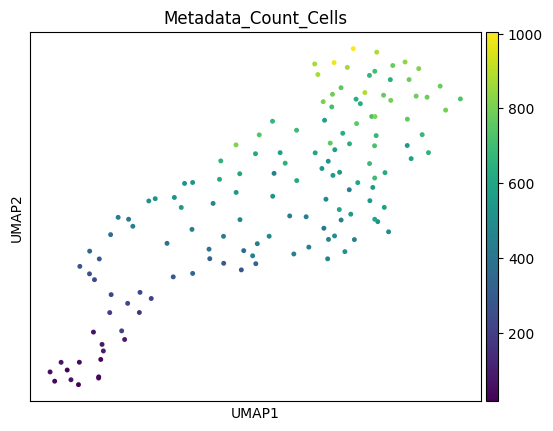

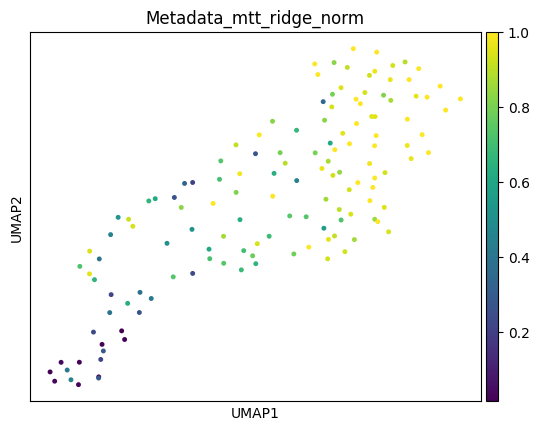

In [106]:
sc.pl.umap(adata, color='Metadata_Count_Cells', size=50)
sc.pl.umap(adata, color='Metadata_mtt_ridge_norm', size=50)

In [109]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

cosine_distance_matrix = squareform(pdist(adata.X, metric='cosine')) 
cosine_similarity_matrix = 1 - cosine_distance_matrix

metadata_count_cells = adata.obs.reset_index()["Metadata_Count_Cells"]
norm = Normalize(vmin=metadata_count_cells.min(), vmax=metadata_count_cells.max())
normalized_counts = norm(metadata_count_cells.to_numpy())

colormap = sns.color_palette("coolwarm", as_cmap=True)
row_colors = colormap(normalized_counts)

# For categorical
metadata_compound = adata.obs.reset_index()["Metadata_Compound"]
compound_colors = pd.Categorical(metadata_compound).codes
unique_categories = metadata_compound.unique()
palette = sns.color_palette("tab10", len(unique_categories))
compound_color_map = dict(zip(unique_categories, palette))

metadata_compound = metadata_compound.reset_index(drop=True)
metadata_compound = metadata_compound.astype(str)
compound_row_colors = metadata_compound.map(compound_color_map).to_numpy()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


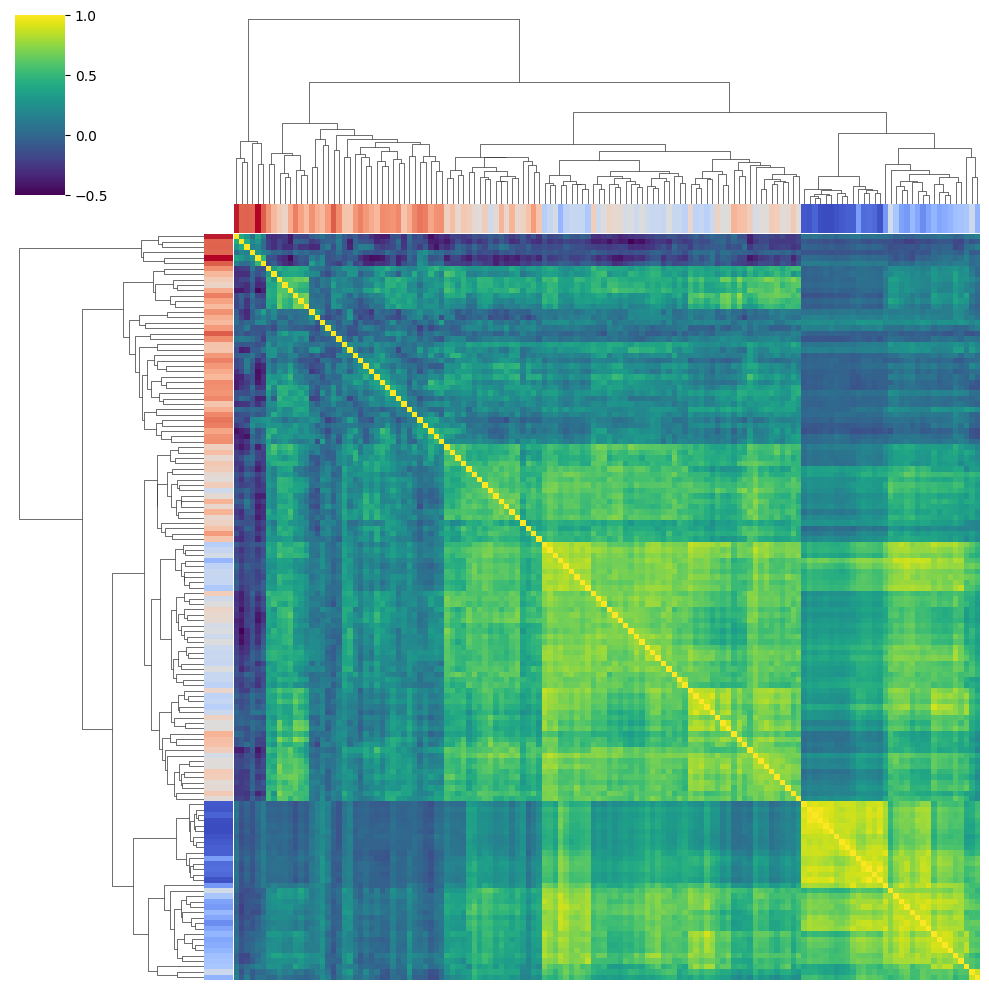

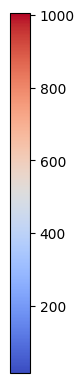

In [107]:
sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 10)
)

from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

norm = Normalize(vmin=metadata_count_cells.min(), vmax=metadata_count_cells.max())
colorbar = plt.figure(figsize=(1, 6))
cb_ax = colorbar.add_axes([0.1, 0.2, 0.2, 0.6])  # [left, bottom, width, height]
ColorbarBase(cb_ax, cmap=colormap, norm=norm, orientation='vertical')
cb_ax.set_label("Cell count")

plt.show()

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 1000x1000 with 0 Axes>

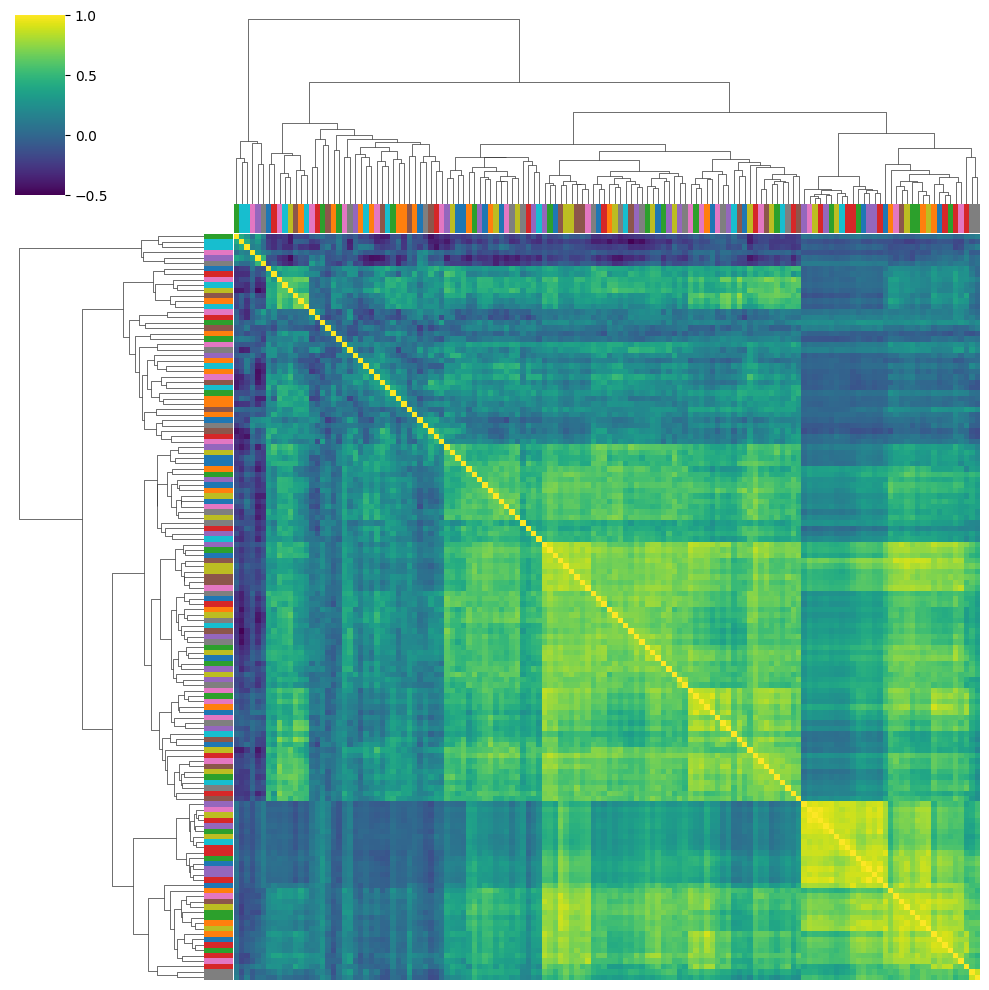

In [110]:
sns.clustermap(
    cosine_similarity_matrix,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    row_colors=compound_row_colors,
    col_colors=compound_row_colors,
    figsize=(10, 10)
)
plt.show()

In [113]:
import random

random.sample(higher_err, 10)

['Enzalutamide_3.82_M11_plate_41002897',
 'Temsirolimus_1.43_A01_plate_41002900',
 'Benzethonium (chloride)_2.86_L22_plate_41002905',
 'Ximelagatran_3.82_A19_plate_41002878',
 'Alfacalcidol_3.82_O23_plate_41002877',
 'Puromycin aminonucleoside_3.34_M06_plate_41002892',
 'Hycanthone_3.34_G16_plate_41002957',
 'Alectinib (Hydrochloride)_3.34_K07_plate_41002956',
 'Rilpivirine_3.82_B17_plate_41002896',
 'Fesoterodine_3.82_A13_plate_41002878']

In [114]:
random.sample(lower_err, 10)

['Nevirapine_3.34_N14_plate_41002956',
 'Capsaicin_3.34_P14_plate_41002701',
 'Ezetimibe_3.82_J18_plate_41002946',
 'Melatonin_3.82_D16_plate_41002692',
 'Safinamide (mesylate)_3.82_L13_plate_41002693',
 'Atenolol_2.86_G22_plate_41002951',
 '2,7-Dihydroxynaphthalene_3.82_M09_plate_41002877',
 'Linagliptin_2.86_J02_plate_41002904',
 'Alpidem_3.82_O17_plate_41002877',
 '5-Azacytidine_2.86_I02_plate_41002951']

In [115]:
dmso = pl.read_parquet("/dgx1nas1/storage/data/jess/repos/2024_09_09_Axiom_OASIS/1_snakemake/outputs/dino/mad_featselect/profiles/mad_featselect.parquet").with_columns(
    pl.col("Metadata_Log10Conc").round(2).alias("Metadata_Log10Conc")
)

dmso = dmso.with_columns(
    pl.concat_str(["Metadata_Compound", "Metadata_Log10Conc", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Metadata_Unique_ID")
).filter(pl.col("Metadata_Compound") == "DMSO").select("Metadata_Unique_ID").to_series().to_list()

random.sample(dmso, 10)

['DMSO_0.0_H22_plate_41002948',
 'DMSO_0.0_H11_plate_41002882',
 'DMSO_0.0_H24_plate_41002890',
 'DMSO_0.0_P11_plate_41002908',
 'DMSO_0.0_F04_plate_41002959',
 'DMSO_0.0_A20_plate_41002879',
 'DMSO_0.0_M04_plate_41002877',
 'DMSO_0.0_H10_plate_41002947',
 'DMSO_0.0_H02_plate_41002692',
 'DMSO_0.0_C04_plate_41002959']